<a href="https://colab.research.google.com/github/irahanjose/Aprendizaje-de-M-quina-con-Python/blob/main/prediccion_riesgo_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto: predicción de riesgo de diabetes

##1 - El problema a resolver

La diabetes es una enfermedad crónica asociada a elevados niveles de azúcar en la sangre.

El problema es que se trata de una enfermedad "silenciosa", difícil de detectar en etapas tempranas, pues muchas veces es asintomática.

La idea es usar el [set de datos de los indígenas Pima](https://www.kaggle.com/uciml/pima-indians-diabetes-database), que contiene múltiples variables predictivas asociadas a la diabetes así como la presencia o ausencia de la enfermedad en una muestra de esta población, para entrenar una Red Neuronal capaz de predecir la probabilidad de aparición de diabetes. 

## 2 - El set de datos

Este set fue obtenido de una población de 768 indígenas, todas mujeres y con edades de 21 años en adelante.

Cada dato corresponde a un sujeto y contiene un total de ocho (8) características (*features*), así como la variable *Outcome* indicando si el sujeto tiene (1) o no (0) la enfermedad:

- *Pregnancies*: número de embarazos
- *Glucose*: concentración de glucosa en plasma
- *BloodPressure*: presión sanguínea diastólica (en mmHg)
- *SkinThickness*: espesor del pliegue cutáneo en el triceps (en mm)
- *Insulin*: nivel de insulina en suero sanguíneo
- *BMI*: índice de masa corporal (peso en kg / (altura en m)^2)
- *DiabetesPedigreeFunction*: una función que representa un puntaje asociado al riesgo de desarrollar la enfermedad, calculado con base en el historial familiar del sujeto
- *Age*: la edad en años del sujeto
- *Outcome*: la categoría a la que pertenece el sujeto. *1* si desarrolló la enfermedad dentro de los 5 años posteriores a la obtención de las variables, *0* si no la desarrolló.

Comencemos realizando la lectura del dataset:

In [ ]:
# Preparar Google Drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# Leer el dataset 
import pandas as pd
ruta = '/gdrive/MyDrive/Colab Notebooks/01_2021-07-FundamentosDL/1.23_1.27/diabetes.csv'
df = pd.read_csv(ruta)

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35.0,113.0,33.6,0.627,50,1
1,1,85,66,29.0,88.5,26.6,0.351,31,0
2,8,183,64,24.0,227.5,23.3,0.672,32,1
3,1,89,66,23.0,94.0,28.1,0.167,21,0
4,0,137,40,35.0,168.0,43.1,2.288,33,1


In [ ]:
df.shape

(768, 9)

Una primera observación es que el dataset contiene muy pocos datos (768). Al hacer la división convencional entre entrenamiento/prueba/validación, se tendrán muy pocos datos de prueba y validación.

Al final veremos qué alternativa se puede usar para validar correctamente el modelo.

##3 - Análisis Exploratorio de los Datos

El primer paso en todo proyecto de Deep Learning es **entender** los datos. Esto implica, entre otras, entender las distribuciones, el rango de valores que tienen y si hay o no datos faltantes.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


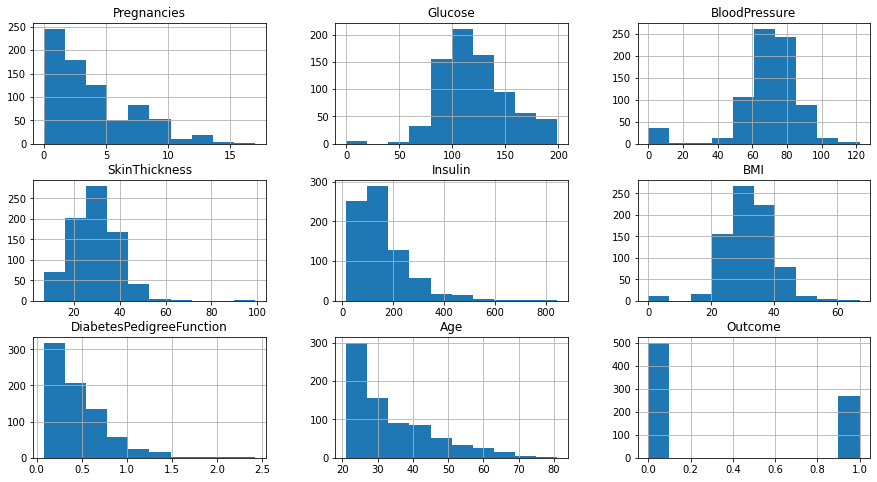

In [ ]:
# Distribución de los datos (histogramas)
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,8))
axes = fig.gca()
df.hist(ax = axes);

Algunas observaciones:

- Las variables *Glucose*, *BloodPressure*, *SkinThickness* y *BMI* tienen una distribución normal (campana Gaussiana).
- Las variables *Pregnancies*, *Insulin*, *DiabetesPedigreeFunction* y *Age* están sesgadas hacia la izquierda.
- Cada variable tiene una escala diferente.
- El set está desbalanceado: hay más sujetos sanos (categoría 0) que enfermos (categoría 1).
- Hay algunos datos "sospechosos": en las variables *Glucose*, *BloodPressure* y *BMI* algunos sujetos presentan valores iguales a 0, ¡lo cual es fisiológicamente imposible!

## 4 - Manejo de datos faltantes

Los datos "sospechosos" pueden corresponder a lo que se conoce como datos faltantes (bien sea porque no fueron tomados en su momento o porque la muestra no fue procesada correctamente).

In [ ]:
# Buscar casillas vacías ("null") en el DataFrame
print(df.isnull().any())

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool


In [ ]:
# Al parecer no hay datos faltantes. Se puede usar describe para 
# obtener una descripción estadística de cada característica
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,29.116536,155.886719,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,9.771631,105.112147,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,7.000000,14.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,22.000000,84.750000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,129.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,35.500000,194.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Observaciones:

- Las variables *Pregnancies*, *Glucose*, *BloodPressure* y *BMI* poseen valores mínimos de 0

In [ ]:
# Miremos qué tantos valores faltantes hay para saber qué estrategia usar

for col in df.columns:
  filas_faltantes = df.loc[df[col]==0].shape[0]
  print(f'{col} : {filas_faltantes}')

Pregnancies : 111
Glucose : 5
BloodPressure : 35
SkinThickness : 0
Insulin : 0
BMI : 11
DiabetesPedigreeFunction : 0
Age : 0
Outcome : 500


Efectivamente faltan datos. En el caso de *Pregnancies* no es necesario hacer ningún procedimiento (pues realmente puede haber individuos con 0 embarazos), pero en los demás casos (*Glucose*, *BloodPressure* y *BMI*) se puede hacer eliminación o imputación.

In [ ]:
# Tratemos de realizar imputación por la media

df_copy = df.copy()

import numpy as np

# Reemplazar 0s con NaN
df_copy['Glucose'] = df_copy['Glucose'].replace(0,np.nan)
df_copy['BloodPressure'] = df_copy['BloodPressure'].replace(0,np.nan)
df_copy['BMI'] = df_copy['BMI'].replace(0,np.nan)

# Reemplazar NaN con el valor promedio de la columna correspondiente
df_copy['Glucose'] = df_copy['Glucose'].fillna(df_copy['Glucose'].mean())
df_copy['BloodPressure'] = df_copy['BloodPressure'].fillna(df_copy['BloodPressure'].mean())
df_copy['BMI'] = df_copy['BMI'].fillna(df_copy['BMI'].mean())

In [ ]:
# Verifiquemos que la distribución de los datos no ha cambiado con la imputación

variables = ['Glucose', 'BloodPressure', 'BMI']

for variable in variables:
  prom_o = df[variable].describe()['mean']
  prom_i = df_copy[variable].describe()['mean']
  std_o = df[variable].describe()['std']
  std_i = df_copy[variable].describe()['std']

  print(f'{variable} (original/imputación):')
  print(f'   promedio: {prom_o:.2f}/{prom_i:.2f}')
  print(f'   desviación: {std_o:.2f}/{std_i:.2f}')

Glucose (original/imputación):
   promedio: 120.89/121.69
   desviación: 31.97/30.44
BloodPressure (original/imputación):
   promedio: 69.11/72.41
   desviación: 19.36/12.10
BMI (original/imputación):
   promedio: 31.99/32.46
   desviación: 7.88/6.88


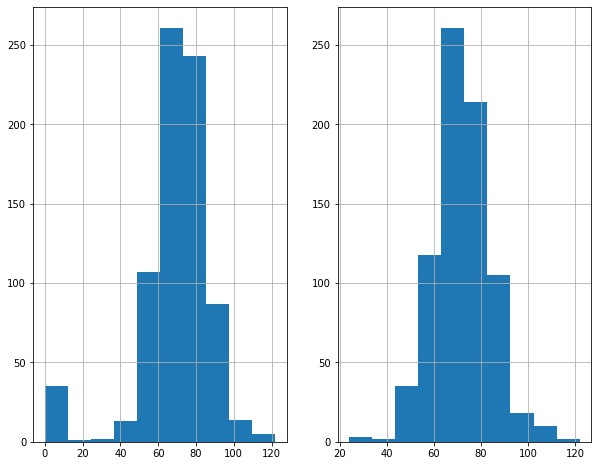

In [ ]:
# Veamos en detalle los cambios en "BloodPressure"

fig = plt.figure(figsize = (10,8))

plt.subplot(121)
axes = fig.gca()
df['BloodPressure'].hist(ax = axes)

plt.subplot(122)
axes = fig.gca()
df_copy['BloodPressure'].hist(ax = axes);

## 5 - Pre-procesamiento: estandarización de los datos

In [ ]:
from sklearn import preprocessing
df_s = preprocessing.scale(df_copy) # Numpy
df_s = pd.DataFrame(df_s, columns=df_copy.columns) # Numpy a pandas
df_s['Outcome'] = df_copy['Outcome']
df_s.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.865108,-0.033518,0.602489,-0.408275,0.166292,0.468492,1.425995,1
1,-0.844885,-1.206162,-0.529859,-0.011934,-0.641511,-0.852531,-0.365061,-0.190672,0
2,1.233880,2.015813,-0.695306,-0.523953,0.681748,-1.332833,0.604397,-0.105584,1
3,-0.844885,-1.074652,-0.529859,-0.626356,-0.589152,-0.634212,-0.920763,-1.041549,0
4,-1.141852,0.503458,-2.680669,0.602489,0.115317,1.548980,5.484909,-0.020496,1


In [ ]:
# Verificar que la media es cero y la desviación es 1
df_s['Insulin'].describe()

count    7.680000e+02
mean    -1.720267e-17
std      1.000652e+00
min     -1.350740e+00
25%     -6.772108e-01
50%     -2.511976e-01
75%      3.628327e-01
max      6.569774e+00
Name: Insulin, dtype: float64

<a name="splitting"></a>
## 6 - Sets de entrenamiento, prueba y validación

Se hará una partición de 80-10-10 %:

In [ ]:
from sklearn.model_selection import train_test_split

# Separación features y labels
X = df_s.iloc[:,:-1].values
Y = df_s.iloc[:,-1].values

# Entrenamiento: 80%, test+validación: 20%
x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=10)

# Test: 10%, validación: 10%
x_test, x_val, y_test, y_val = train_test_split(x_temp,y_temp, test_size=0.5, random_state=10)

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(614, 8)
(77, 8)
(77, 8)


##7 - Modelos base

Al no tener un referente crearemos dos modelos de diferente complejidad:

- Modelo 1: 1 capa oculta con 4 neuronas (punto medio entre 8 y 1)
- Modelo 2: 2 capas ocultas con 5 y 2 neuronas c/u

Con esto tendremos una idea de qué tan buenos son y luego podremos refinarlos.

In [ ]:
# Función auxiliar para la creación de redes
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import numpy as np
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DIM_ENTRADA = x_train.shape[1]   # 8 datos
DIM_SALIDA = 1                   # Una de dos posibles categorías (0 ó 1)

def crear_modelo(dim_entrada, dim_salida, capas, nombre='', flag_print=True):
  mod = Sequential()

  # Capa de entrada
  mod.add(Dense(capas[0], activation='relu', input_shape=(dim_entrada,), name='capa_1'))

  # Continuar agregando capas (si hay más de una oculta)
  if len(capas)>1:
    i = 1
    while i < len(capas):
      mod.add(Dense(capas[i], activation='relu', name='capa_'+str(i+1)))
      i += 1
  
  # Capa de salida
  mod.add(Dense(dim_salida, activation='sigmoid', name='capa_salida'))
  
  mod._name = nombre
  
  if flag_print:
    mod.summary()

  return mod

In [ ]:
capas1 = [4]
capas2 = [5, 2]
modelo1 = crear_modelo(DIM_ENTRADA, DIM_SALIDA, capas1, 'modelo_1')
modelo2 = crear_modelo(DIM_ENTRADA, DIM_SALIDA, capas2,'modelo_2')

Model: "modelo_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
capa_1 (Dense)               (None, 4)                 36        
_________________________________________________________________
capa_salida (Dense)          (None, 1)                 5         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
Model: "modelo_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
capa_1 (Dense)               (None, 5)                 45        
_________________________________________________________________
capa_2 (Dense)               (None, 2)                 12        
_________________________________________________________________
capa_salida (Dense)          (None, 1)                 3         
Total params: 60
Trainable params: 60
Non-tr

##8 - Entrenamiento y prueba

In [ ]:
from tensorflow.keras.optimizers import SGD

def compilar_entrenar(modelo, n_epochs=1000, tam_lote=None):
  opt = SGD(learning_rate=0.5)
  modelo.compile(optimizer=opt, loss='binary_crossentropy',
                 metrics=['accuracy'])
  
  hist = modelo.fit(
      x_train, y_train, epochs=n_epochs, validation_data=(x_test,y_test),
      batch_size = tam_lote, verbose=0)

  # Al final del entrenamiento imprimir en pantalla la precisión lograda
  # con los sets de entrenamiento y prueba
  acc_train = modelo.evaluate(x_train,y_train,verbose=0)
  acc_test = modelo.evaluate(x_test,y_test,verbose=0)

  print(f'{modelo.name} - exactitud entrenamiento/prueba: {100*acc_train[1]:.2f}%/{100*acc_test[1]:.2f}%')

  return hist

In [ ]:
TAM_LOTE = x_train.shape[0]
historia1 = compilar_entrenar(modelo1, tam_lote=TAM_LOTE)
historia2 = compilar_entrenar(modelo2, tam_lote=TAM_LOTE)

modelo_1 - exactitud entrenamiento/prueba: 79.15%/71.43%
modelo_2 - exactitud entrenamiento/prueba: 81.11%/80.52%


In [ ]:
# Comportamiento de la pérdida y la precisión
import matplotlib.pyplot as plt

def graficar(historia):
  plt.figure(figsize=(15,5))

  loss = historia.history['loss']
  accuracy = historia.history['accuracy']
  test_loss = historia.history['val_loss']
  test_accuracy = historia.history['val_accuracy']
  epochs = historia.epoch

  plt.subplot(121)
  plt.plot(epochs,loss,label='train_loss')
  plt.plot(epochs,test_loss,'b--',label='test_loss')
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs,accuracy,label='train_acc')
  plt.plot(epochs,test_accuracy,'b--',label='test_acc')
  plt.legend()

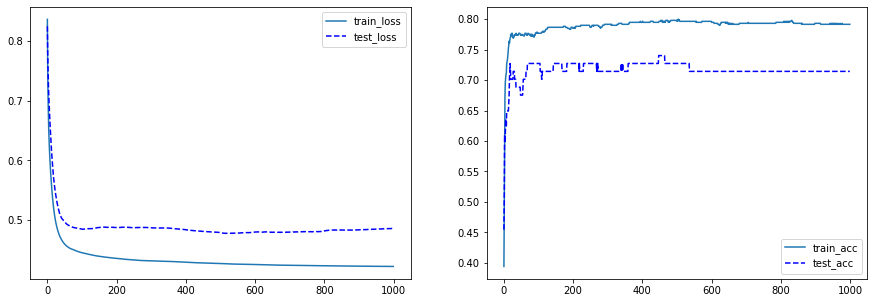

In [ ]:
graficar(historia1)

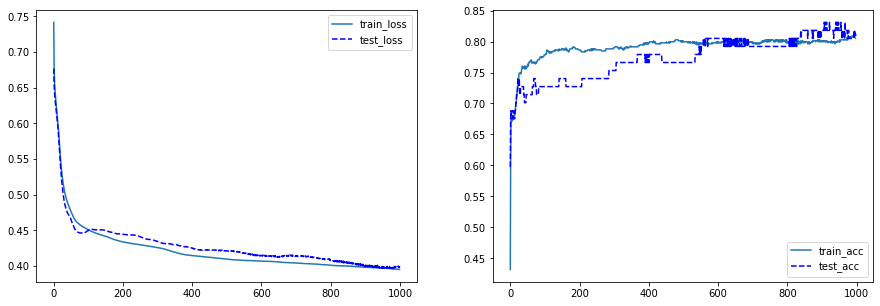

In [ ]:
graficar(historia2)

In [ ]:
# Validación (set de validación)
puntaje1 = modelo1.evaluate(x_val,y_val,verbose=0)
puntaje2 = modelo2.evaluate(x_val,y_val,verbose=0)

print(f'Validación modelo 1: exactitud {100*puntaje1[1]:.2f}%')
print(f'Validación modelo 2: exactitud {100*puntaje2[1]:.2f}%')

# ¡Parece ser mejor el modelo 1!

Validación modelo 1: exactitud 77.92%
Validación modelo 2: exactitud 76.62%


El problema de este entrenamiento, prueba y validación es que el set está desbalanceado y hay muy pocos datos:

- Se entrenó con 614 datos
- Se probó con 77 datos
- Se validó con 77 datos

Estos datos están distribuidos así:

In [ ]:
# Entrenamiento
n_train = y_train[y_train==0].shape[0]  # Normales entrenamiento
e_train = y_train[y_train==1].shape[0]  # Enfermos entrenamiento
pctj_n_train = n_train/(n_train+e_train)
pctj_e_train = 1 - pctj_n_train

# Prueba
n_test = y_test[y_test==0].shape[0]  # Normales prueba
e_test = y_test[y_test==1].shape[0]  # Enfermos prueba
pctj_n_test = n_test/(n_test+e_test)
pctj_e_test = 1 - pctj_n_test

# Validación
n_val = y_val[y_val==0].shape[0]  # Normales entrenamiento
e_val = y_val[y_val==1].shape[0]  # Enfermos entrenamiento
pctj_n_val = n_val/(n_val+e_val)
pctj_e_val = 1 - pctj_n_val

print(f'Entrenamiento: {100*pctj_n_train:.0f}% normales, {100*pctj_e_train:.0f}% enfermos')
print(f'Prueba: {100*pctj_n_test:.0f}% normales, {100*pctj_e_test:.0f}% enfermos')
print(f'Validación: {100*pctj_n_val:.0f}% normales, {100*pctj_e_val:.0f}% enfermos')

Entrenamiento: 66% normales, 34% enfermos
Prueba: 65% normales, 35% enfermos
Validación: 58% normales, 42% enfermos


- Para entrenamiento y prueba se tienen prácticamente las mismas proporciones, pero en la validación son diferentes (hay más enfermos que en los casos anteriores)
- Esto afecta la validación final con cada modelo
- Es decir que el desempeño del modelo no dependerá del modelo mismo, sino más bien de los datos con los que está siendo entrenado (que son muy pocos)

¿Qué alternativa existe para una validación más robusta?

##9 - Cross-validation

Cuando se tienen pocos datos de entrenamiento se sugiere NO dividirlos en entrenamiento-prueba-validación (usualmente 80-10-10), pues de hacerlo los sets de prueba y validación no serán una muestra representativa.

Con *k-fold cross-validation* se evita este sesgo y se tiene una validación más robusta.

La idea general es:
- Generar *k* particiones del set de datos
- Entrenar *k* veces cada modelo. En cada entrenamiento:
  - *k-1* particiones se usan para entrenamiento y la partición restante para prueba. No hay validación
  - La partición de prueba cambia en cada entrenamiento

![](https://drive.google.com/uc?export=view&id=1hW-LZcm1Avzo69Nm3QKEEQU_HlVdjkTG)

Al final del entrenamiento se calcula el promedio y la desviación de las métricas de desempeño (*accuracy*) para los *k* entrenamientos, y se escoge el modelo con el mejor desempeño promedio.

Finalmente se entrena este modelo escogido con **la totalidad** del set de datos.

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

def kfold_crossvalidation(capas, nfolds, X, Y):

  kfold = StratifiedKFold(n_splits=nfolds, shuffle=True)

  nfold = 1
  acc_fold = []

  opt = SGD(learning_rate=0.5)
  NEPOCHS = 1000
  for train, test in kfold.split(X,Y):

    # Crear el modelo
    modelo = crear_modelo(DIM_ENTRADA, DIM_SALIDA, capas, flag_print=False)

    # Compilar y entrenar
    print('-------------------------------------------------------------------')
    print(f'Entrenando fold {nfold}...')

    modelo.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    hist = modelo.fit(
        X[train], Y[train], epochs=NEPOCHS, batch_size = X[train].shape[0], verbose=0
        )
    
    # Calcular 'accuracy' para entrenamiento y prueba para cada modelo entrenado
    acc_train = modelo.evaluate(X[train],Y[train],verbose=0)
    acc_test = modelo.evaluate(X[test],Y[test],verbose=0)

    print(f'{modelo.name} - Exactitud (accuracy) entrenamiento/prueba: {100*acc_train[1]:.2f}%/{100*acc_test[1]:.2f}%')

    acc_fold.append(acc_test[1] * 100)

    nfold += 1

  print('-------------------------------------------------------------------')
  print(f'Exactitud promedio set de prueba para {nfolds} folds: {np.mean(acc_fold):.2f} +- {np.std(acc_fold):.2f}')

In [ ]:
kfold_crossvalidation([4], 5, X, Y)

-------------------------------------------------------------------
Entrenando fold 1...
 - Exactitud (accuracy) entrenamiento/prueba: 80.29%/75.97%
-------------------------------------------------------------------
Entrenando fold 2...
 - Exactitud (accuracy) entrenamiento/prueba: 79.32%/79.87%
-------------------------------------------------------------------
Entrenando fold 3...
 - Exactitud (accuracy) entrenamiento/prueba: 81.11%/77.92%
-------------------------------------------------------------------
Entrenando fold 4...
 - Exactitud (accuracy) entrenamiento/prueba: 80.81%/75.82%
-------------------------------------------------------------------
Entrenando fold 5...
 - Exactitud (accuracy) entrenamiento/prueba: 81.63%/75.16%
-------------------------------------------------------------------
Exactitud promedio set de prueba para 5 folds: 76.95 +- 1.73


In [ ]:
kfold_crossvalidation([5, 2], 5, X, Y)

-------------------------------------------------------------------
Entrenando fold 1...
 - Exactitud (accuracy) entrenamiento/prueba: 83.55%/71.43%
-------------------------------------------------------------------
Entrenando fold 2...
 - Exactitud (accuracy) entrenamiento/prueba: 83.06%/75.97%
-------------------------------------------------------------------
Entrenando fold 3...
 - Exactitud (accuracy) entrenamiento/prueba: 77.85%/81.17%
-------------------------------------------------------------------
Entrenando fold 4...
 - Exactitud (accuracy) entrenamiento/prueba: 82.28%/77.78%
-------------------------------------------------------------------
Entrenando fold 5...
 - Exactitud (accuracy) entrenamiento/prueba: 79.35%/73.20%
-------------------------------------------------------------------
Exactitud promedio set de prueba para 5 folds: 75.91 +- 3.42


El modelo 1 es ligeramente mejor que el modelo 2 (mayor promedio de exactitud y menor varianza).

Finalmente, el modelo definitivo se entrena con la totalidad del dataset y puede ser almacenado en un archivo para posteriores predicciones:

In [ ]:
modelo = crear_modelo(DIM_ENTRADA, DIM_SALIDA, [4], 'modelo_final')
opt = SGD(learning_rate=0.5)
modelo.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
hist = modelo.fit(X, Y, epochs=1000, batch_size=X.shape[0], verbose=1)
#modelo.save('/gdrive/MyDrive/Colab Notebooks/01_2021-07-FundamentosDL/1.23/modelo.h5')
#modelo = modelo.load(ruta)


## 10 - Conclusiones y sugerencias finales

- Siempre al inicio de un proyecto de Deep Learning es esencial realizar al menos tres etapas: análisis exploratorio, manejo de datos faltantes (si aplica) y normalización/estandarización de los datos
- Cuando se tienen pocos datos de entrenamiento se sugiere usar validación cruzada (*k-fold cross-validation*)

Sugerencias:
- Intentar mejorar el modelo final, modificando diferentes hiperparámetros (número de neuronas, tasa de aprendizaje, tamaño de lote, número de iteraciones) y en cada caso hacer validación cruzada.